## Customer Analysis (Telecom Company) 

This notebook will be a walk-through of an exploratory analysis of the customers for a telecom company. The company is interested in developing a classification model that can predict whether or not a customer will churn. In addition to this model, they are looking for additional insights into how they can optimize their business, to best serve their customers.

* Question 1: What type of phone call is generating the most money for the company? daytime, evening, night, or international? 
* Question 2: Are customers using more minutes during the day or at night?
* Question 3: Which state is using the most minutes overall?
* Question 4: Which state is generating the most service calls?
* Question 5: Is the number of service calls made by a customer correlated to churn

The hope is that model will help them make better predictions of when a customer might churn. With some more detail on the behavior of the customers, the company can make better decisions in terms of staffing as well as resource allocation. This Notebook will be accompanied by a tableau dashboard which can be found here: https://public.tableau.com/app/profile/cole.howson/viz/ColeHowsonCapstoneProject/Dashboard1?publish=yes

The tableau dashboard is meant to be used as a way to surface updated data. The dashboard could be updated frequently, and used to get a overview of some kpi's of the company. The dashboard could be further customized to meet the needs of different departments. 


## Importing Necessary Libraries 

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import math# import libraries required
import statsmodels.api as sm


# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# import evaluation functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score


# scikitplot to directly plot our results
import graphviz
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

## Bringing in Data from Google Big Query



The company has been collecting data and storing it in a relational database in Google Big Query. The data is currently in two tables. I decided since the tables have the exact same column and row structure, I would use UNION ALL to combine them into one large dataset with SQL, before bringing it into python. The company has given us access to the key for the database, we will use that to import the data into Python.

In [3]:
# Setting up the Google Environment 
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/ch/Desktop/Capstone 2 /cole-howson-capstone-project-2-5947b94f4b0e.json'    

In [4]:
# This code will make the call the BigQuery's API and return the table in a Panada's Data Frame 
import time
from google.cloud import bigquery

# Similar to how you would write a query in SQL. Using * to pull all the tables information
query = "select * from customer_churn.churn_100"

client = bigquery.Client()
query_job = client.query(query)

time.sleep(2) #give the query some time to finish
result = query_job.result()

# Assigning the Query Results to the varible df for recall later in the analysis 
df = result.to_dataframe()
df.head(10)


,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,MI,146,408,False,False,0,149.3,83,25.38,187.1,130,15.90,149.8,100,6.74,7.9,4,2.13,7,True
1,HI,99,408,False,False,0,135.7,107,23.07,208.4,103,17.71,209.0,95,9.40,8.8,3,2.38,7,True
2,NH,103,408,False,False,0,150.6,125,25.60,169.1,126,14.37,221.2,104,9.95,10.4,8,2.81,8,True
3,NJ,53,408,False,False,0,228.6,117,38.86,132.8,123,11.29,227.2,124,10.22,10.1,2,2.73,9,True
4,KY,122,408,False,True,27,253.7,84,43.13,229.2,109,19.48,190.5,123,8.57,9.2,5,2.48,7,False
5,GA,136,415,False,False,0,163.4,83,27.78,249.3,119,21.19,249.7,90,11.24,9.8,4,2.65,7,False
6,AR,115,415,False,False,0,139.3,89,23.68,192.3,95,16.35,151.0,75,6.80,9.3,3,2.51,7,True
7,AL,86,415,False,False,0,128.3,121,21.81,197.1,93,16.75,138.4,152,6.23,12.2,5,3.29,7,True
8,VT,99,415,False,False,0,115.5,75,19.64,218.1,111,18.54,254.9,98,11.47,11.5,7,3.11,7,True
9,OH,93,415,False,True,42,152.3,90,25.89,267.5,102,22.74,266.9,130,12.01,11.3,5,3.05,7,False


## Question 1: What type of phone call is generating the most money for the company? Day, evening, night or, international.



In [6]:
# Total charges for all day time calls 
df['Total_day_charge'].sum()


101864.17

In [7]:
# Total charges for all evening calls 
df['Total_eve_charge'].sum()

56939.44

In [8]:
# Total Charges for all night calls 
df['Total_night_charge'].sum()

30128.07

In [9]:
# Total charges for all international calls 
round(df['Total_intl_charge'].sum(),2) # using round to get the decimal point to 2 places 

9214.35

#### Creating a data frame with aggregated charges information(for visulization)

In [10]:
#Creating two lists from the aggregated data above
call_types = ['Day Time Call', 'Evening Call', 'Night Call', 'International Call']
total_charges = [101864.17,56939.44,30128.07,9214.35]

#Converting the lists to a Series
call_series = pd.Series(call_types)
charges_series = pd.Series(total_charges)

#Converting the two series to a single dictionary
frame = { 'Call Type': call_series, 'Total Charges': charges_series }

#Converting the dictionary to a Pandas Data Frame
charge_df = pd.DataFrame(frame)

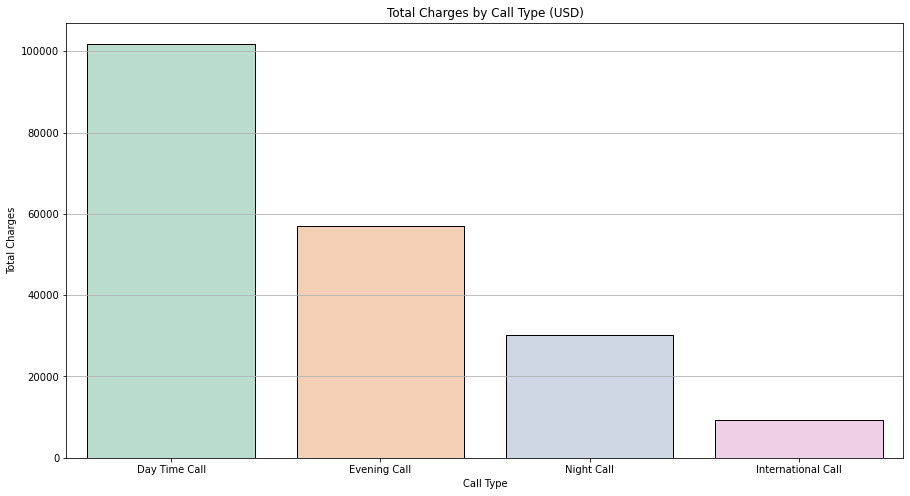

In [11]:
#displaying charge_df as a bar plot with plt. and sns.
plt.figure(figsize=(15,8))
plt.grid()
plt.title('Total Charges by Call Type (USD)')
sns.barplot(data = charge_df, x = 'Call Type', y = "Total Charges", palette = 'Pastel2', edgecolor ="black");

**From graphing our results the majority of the company's income is generated by daytime calls. The weakest performing category is by far international calls.**


## Question 2: What is the average call lengths for each type of call and,  are customers using more minutes at a certain time of day?



In [12]:
df.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,MI,146,408,False,False,0,149.3,83,25.38,187.1,130,15.90,149.8,100,6.74,7.9,4,2.13,7,True
1,HI,99,408,False,False,0,135.7,107,23.07,208.4,103,17.71,209.0,95,9.40,8.8,3,2.38,7,True
2,NH,103,408,False,False,0,150.6,125,25.60,169.1,126,14.37,221.2,104,9.95,10.4,8,2.81,8,True
3,NJ,53,408,False,False,0,228.6,117,38.86,132.8,123,11.29,227.2,124,10.22,10.1,2,2.73,9,True
4,KY,122,408,False,True,27,253.7,84,43.13,229.2,109,19.48,190.5,123,8.57,9.2,5,2.48,7,False


**Creating Columns for average call lengths**

In [13]:
df['Avg Day Call Length'] = round(df['Total_day_minutes'] / df['Total_day_calls'],2)

In [14]:
df['Avg Eve Call Length'] = round(df['Total_eve_minutes'] / df['Total_eve_calls'],2)

In [15]:
df['Avg Night Call Length'] = round(df['Total_night_minutes'] / df['Total_night_calls'],2)

In [16]:
df['Avg Intl Call Length'] = round(df['Total_intl_minutes'] / df['Total_intl_calls'],2)

**Calculating each new columns average below**

In [17]:
round(df['Avg Day Call Length'].mean(),2)

1.87

In [18]:
round(df['Avg Eve Call Length'].mean(),2)

2.1

In [19]:
round(df['Avg Night Call Length'].mean(),2)

2.09

In [20]:
round(df['Avg Intl Call Length'].mean(),2)

3.11

In [21]:
#Creating two lists from the aggregated data above
call_type = ['Day Time', 'Evening', 'Night ', 'International ']
avg_length= [1.87, 2.1, 2.09, 3.11]

#Converting the lists to a series
call_type_series = pd.Series(call_type)
avg_length_series = pd.Series(avg_length)

#Converting the two series to a single dictionary
frame3 = { 'Call Type': call_type_series, 'Avg. Length': avg_length_series }

#Converting the dictionary to a Pandas Data Frame
length_df = pd.DataFrame(frame3)

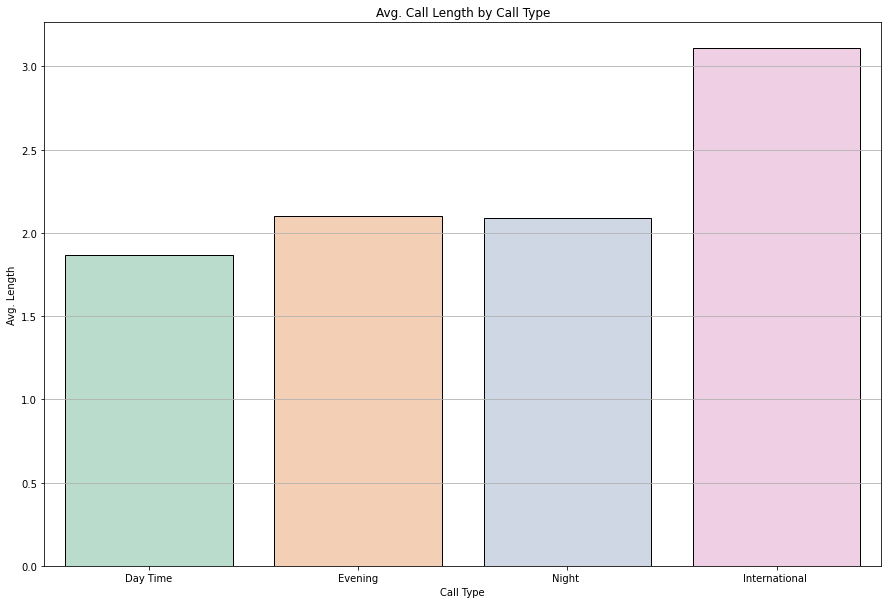

In [22]:
plt.figure(figsize=(15,10))
plt.grid()
plt.title('Avg. Call Length by Call Type')
sns.barplot(data = length_df, x = 'Call Type', y = "Avg. Length", palette = 'Pastel2', edgecolor ="black");

**Although international calls make up the lowest amount of total calls, they last on average longer than any other call category**

#### Summing the total minutes for each call type 


In [23]:
df['Total_day_minutes'].sum()

599190.4

In [24]:
df['Total_eve_minutes'].sum()

669867.5

In [25]:
df['Total_night_minutes'].sum()

669506.5

#### Creating a data frame with aggregated minutes information

In [26]:
time_of_day = ['Day Time Minutes', 'Evening Minutes', 'Night Minutes']
total_minutes = [599190.40,669867.5,669506.5]

time_of_day_series = pd.Series(time_of_day)
total_minutes_series = pd.Series(total_minutes)

frame2 = { 'time_of_day': time_of_day_series, 'total_minutes': total_minutes_series }

minutes_df = pd.DataFrame(frame2)

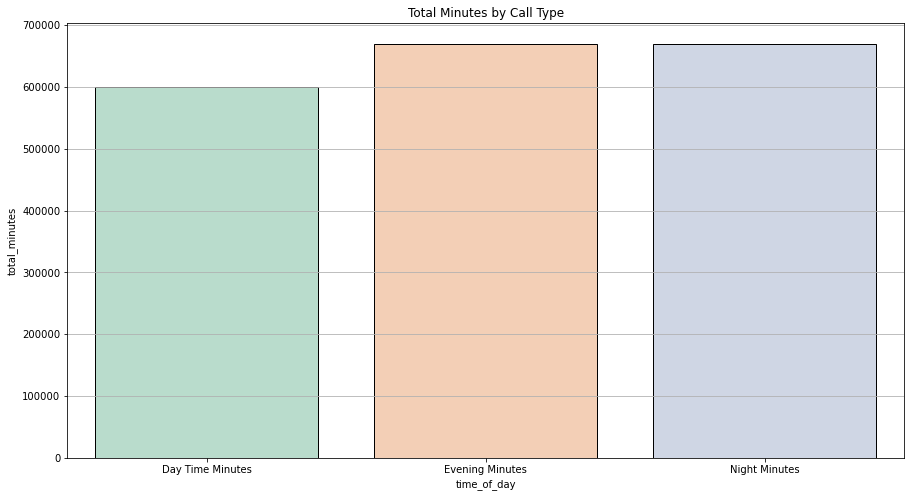

In [27]:
plt.figure(figsize=(15,8))
plt.grid()
plt.title('Total Minutes by Call Type')
sns.barplot(data = minutes_df, x = 'time_of_day', y = "total_minutes", palette = 'Pastel2', edgecolor ="black");

**Looks like customers are making calls pretty consistantly across the day. There is just slight edge towards evening and night. With the slight increase into the evening and night, additional staffing might be required for the service centres.**

## Question 3: Which states are using the most minutes overall

In [28]:
# Making sure states are all included and labelled correctly 
df['State'].unique()

array(['MI', 'HI', 'NH', 'NJ', 'KY', 'GA', 'AR', 'AL', 'VT', 'OH', 'MN',
       'SC', 'KS', 'WI', 'TX', 'WA', 'FL', 'CA', 'DE', 'RI', 'MA', 'AZ',
       'PA', 'CO', 'ME', 'MS', 'AK', 'DC', 'SD', 'CT', 'WV', 'NM', 'UT',
       'VA', 'LA', 'OR', 'NC', 'MD', 'ID', 'TN', 'NV', 'OK', 'WY', 'MT',
       'IL', 'MO', 'NY', 'NE', 'IN', 'ND', 'IA'], dtype=object)

#### Creating function to find and replace state codes 

In [29]:
# This function will make the following conversions if the condition is True. I will then apply this function to the 'State' column
def state_replace(name):
    if name == 'MI':
        return 'Michigan'
    if name == 'HI':
        return 'Hawaii'
    if name == 'NH':
        return 'New Hampshire'
    if name == 'NJ':
        return 'New Jersey'
    if name == 'KY':
        return 'Kentucky'
    if name == 'GA':
        return 'Georgia'
    if name == 'AR':
        return 'Arkansas'
    if name == 'AL':
        return 'Alabama'
    if name == 'VT':
        return 'Vermont'
    if name == 'OH':
        return 'Ohio'
    if name == 'MN':
        return 'Minnesota'
    if name == 'SC':
        return 'South Carolina'
    if name == 'KS':
        return 'Kansas'
    if name == 'WI':
        return 'Wisconsin'
    if name == 'TX':
        return 'Texas'
    if name == 'WA':
        return 'Washington'
    if name == 'FL':
        return 'Florida'
    if name == 'CA':
        return 'California'
    if name == 'DE':
        return 'Delaware'
    if name == 'RI':
        return 'Rhode Island'
    if name == 'MA':
        return 'Massachusetts'
    if name == 'AZ':
        return 'Arizona'
    if name == 'PA':
        return 'Pennsylvania'
    if name == 'CO':
        return 'Colorado'
    if name == 'ME':
        return 'Maine'
    if name == 'MS':
        return 'Mississippi'
    if name == 'AK':
        return 'Alaska'
    if name == 'DC':
        return 'District of Columbia'
    if name == 'SD':
        return 'South Dakota'
    if name == 'CT':
        return 'Connecticut'
    if name == 'WV':
        return 'West Virginia'
    if name == 'NM':
        return 'New Mexico'
    if name == 'UT':
        return 'Utah'
    if name == 'VA':
        return 'Virginia'
    if name == 'LA':
        return 'Louisiana'
    if name == 'OR':
        return 'Oregon'
    if name == 'NC':
        return 'North Carolina'
    if name == 'MD':
        return 'Maryland'
    if name == 'ID':
        return 'Idaho'
    if name == 'TN':
        return 'Tennessee'
    if name == 'NV':
        return 'Nevada'
    if name == 'OK':
        return 'Oklahoma'
    if name == 'WY':
        return 'Wyoming'
    if name == 'MT':
        return 'Montana'
    if name == 'IL':
        return 'Illinois'
    if name == 'MO':
        return 'Missouri'
    if name == 'NY':
        return 'New York'
    if name == 'NE':
        return 'Nebraska'
    if name == 'IN':
        return 'Indiana'
    if name == 'ND':
        return 'North Dakota'
    if name == 'IA':
        return 'Iowa'
    else: 
        return 'null'

#### Applying function to the State column

In [30]:
df['State'] = df['State'].apply(state_replace)

#### Creating a new column totaling up each customers total minutes used 

In [31]:
df['All Minutes'] = df['Total_day_minutes'] + df['Total_eve_minutes'] + df['Total_night_minutes'] + df['Total_intl_minutes']     

In [32]:
pd.set_option('display.max_columns', None)
df.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,Avg Day Call Length,Avg Eve Call Length,Avg Night Call Length,Avg Intl Call Length,All Minutes
0,Michigan,146,408,False,False,0,149.3,83,25.38,187.1,130,15.90,149.8,100,6.74,7.9,4,2.13,7,True,1.80,1.44,1.50,1.98,494.1
1,Hawaii,99,408,False,False,0,135.7,107,23.07,208.4,103,17.71,209.0,95,9.40,8.8,3,2.38,7,True,1.27,2.02,2.20,2.93,561.9
2,New Hampshire,103,408,False,False,0,150.6,125,25.60,169.1,126,14.37,221.2,104,9.95,10.4,8,2.81,8,True,1.20,1.34,2.13,1.30,551.3
3,New Jersey,53,408,False,False,0,228.6,117,38.86,132.8,123,11.29,227.2,124,10.22,10.1,2,2.73,9,True,1.95,1.08,1.83,5.05,598.7
4,Kentucky,122,408,False,True,27,253.7,84,43.13,229.2,109,19.48,190.5,123,8.57,9.2,5,2.48,7,False,3.02,2.10,1.55,1.84,682.6


**Before diving into State level analysis, I would like to see how the customers are distributed across the states.**

In [33]:
#counting the number of customers per state
df.groupby('State').size().sort_values(ascending = False)

State
West Virginia           106
Minnesota                84
New York                 83
Alabama                  80
Wisconsin                78
Oregon                   78
Ohio                     78
Virginia                 77
Wyoming                  77
Connecticut              74
Idaho                    73
Vermont                  73
Michigan                 73
Texas                    72
Utah                     72
Indiana                  71
Maryland                 70
Kansas                   70
Montana                  68
New Jersey               68
North Carolina           68
Nevada                   66
Colorado                 66
Washington               66
Rhode Island             65
Massachusetts            65
Mississippi              65
Arizona                  64
Florida                  63
Missouri                 63
Maine                    62
New Mexico               62
North Dakota             62
Delaware                 61
Nebraska                 61
Oklahoma      

In [34]:
df.groupby('State')['All Minutes'].sum().sort_values(ascending = False)

State
West Virginia           60789.7
Minnesota               50636.6
New York                48585.1
Ohio                    47151.3
Virginia                46587.4
Alabama                 46324.0
Oregon                  45862.2
Wyoming                 45858.1
Wisconsin               45674.0
Vermont                 44131.5
Connecticut             44031.2
Indiana                 43972.0
Michigan                43216.4
Idaho                   42801.9
Kansas                  42621.9
Texas                   42274.9
Maryland                42196.4
Utah                    41735.8
New Jersey              41596.1
North Carolina          40445.4
Montana                 39668.4
Massachusetts           39561.9
Nevada                  39469.6
Washington              39097.6
Colorado                38634.2
Rhode Island            38510.3
Mississippi             38325.3
Florida                 37548.3
North Dakota            37483.2
Missouri                37164.0
Maine                   36865.5
Ne

**The usage of minutes seems to be more or less evenly spread across the country. Looks like the top users are West Virgina, Minnesota and New York as are the majority of customers.**

In [35]:
# On the fly code to calculate the average amount of minutes used by customers in each state
# I don't want to use this in my model so I am just saving it to a variable 
minutes_per_customer = df.groupby('State')['All Minutes'].sum() / df.groupby('State').size()
print(round(minutes_per_customer.sort_values(ascending = False)))

State
Indiana                 619.0
New Jersey              612.0
Kansas                  609.0
Massachusetts           609.0
Tennessee               607.0
Virginia                605.0
North Dakota            605.0
Vermont                 605.0
Ohio                    605.0
South Dakota            604.0
Minnesota               603.0
Maryland                603.0
Nevada                  598.0
Nebraska                597.0
Delaware                597.0
Florida                 596.0
Wyoming                 596.0
Connecticut             595.0
North Carolina          595.0
Maine                   595.0
New Hampshire           594.0
New Mexico              594.0
Georgia                 593.0
Arkansas                593.0
Rhode Island            592.0
Washington              592.0
Michigan                592.0
California              591.0
Missouri                590.0
Mississippi             590.0
Oregon                  588.0
Texas                   587.0
Louisiana               587.0
Penn

In [36]:
#Creating Total Spend Column 
df['total_spend'] = df['Total_day_charge'] + df['Total_eve_charge'] + df['Total_night_charge'] + df['Total_intl_charge']

In [38]:
# Total Amount Spent By State
df.groupby('State')['total_spend'].sum().sort_values(ascending = False)

State
West Virginia           6079.48
Minnesota               5071.19
New York                4843.77
Alabama                 4755.43
Ohio                    4733.69
Virginia                4615.30
Wyoming                 4611.81
Oregon                  4592.00
Wisconsin               4589.03
Indiana                 4457.93
Vermont                 4413.51
Michigan                4374.32
Connecticut             4372.22
Maryland                4345.30
Kansas                  4332.04
Idaho                   4296.81
Texas                   4282.55
Utah                    4258.63
New Jersey              4244.56
North Carolina          4097.17
Montana                 3974.84
Massachusetts           3946.19
Washington              3917.56
Nevada                  3916.43
Colorado                3905.78
Mississippi             3846.68
North Dakota            3788.76
Rhode Island            3787.24
Florida                 3775.89
Maine                   3731.58
South Dakota            3675.33
Mi

**The amount spent is strongly corellated to minutes used. This is to be expected.**

## Question 4: Which states are generating the most service calls

In [122]:
df.groupby('State')['Customer_service_calls'].sum().sort_values(ascending = False).to_frame()


,Customer_service_calls
State,
West Virginia,159
New York,142
Oregon,135
Minnesota,130
Vermont,127
Alabama,125
Virginia,123
Idaho,122
Indiana,120


**Interesting to see some of the top ten states for service calls are not in the top ten for minutes used. Perhaps might be worth investigating what is going on in: Michigan, Idaho, Indiana and Vermont.** 

## Question 5: Are service calls correlated to churn?

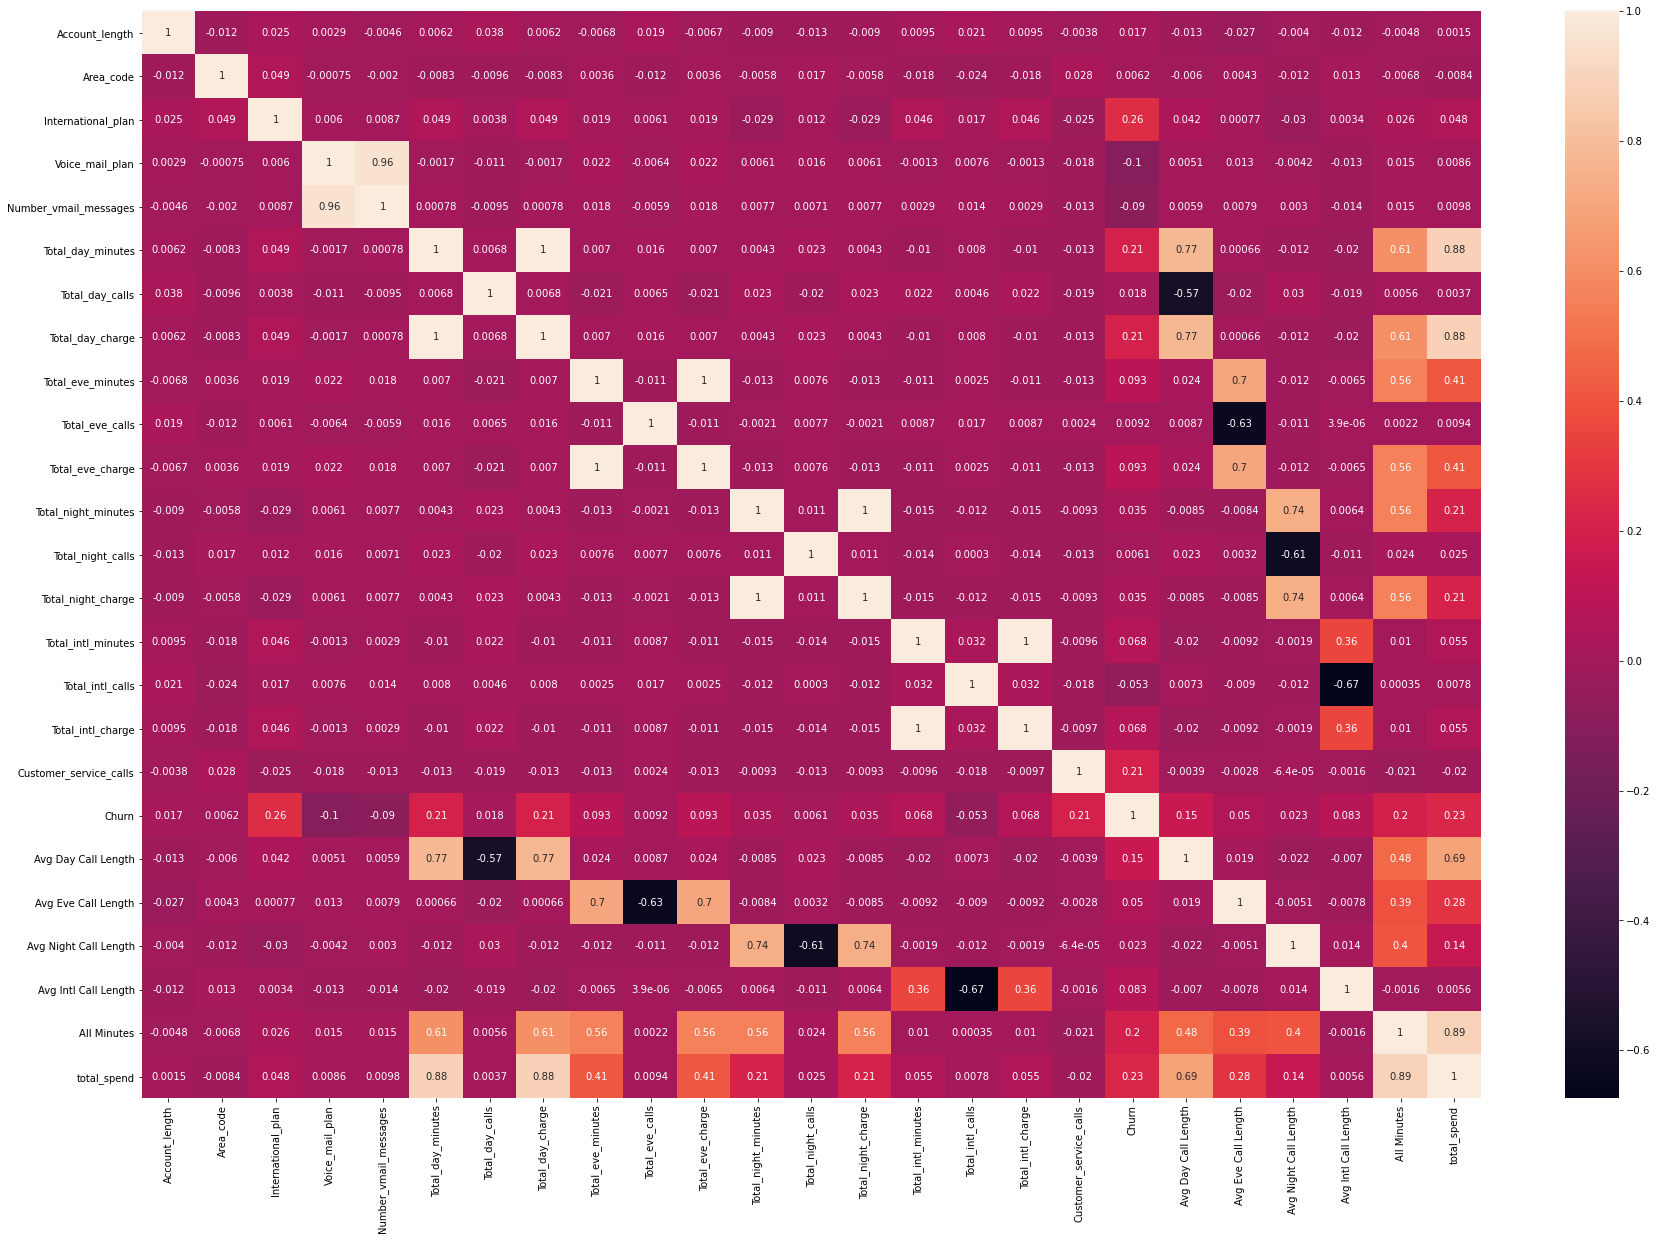

In [123]:
# making use of a heat map to better display findings from correlation matrix
correlationanalysis = df.corr()
plt.figure(figsize=(30,20))
sns.heatmap(correlationanalysis,annot=True );

**Overall the correlation between independent variables is quite weak. There are a few strong correlations that I expected to see. These would be the correlation between the charges for a call and the number of minutes used. As well as the number of voicemails and having a voicemail plan.** 

**The correlations I am interested in are regarding customer churn. International plan, total_day minutes, customer service calls have a stronger correlation to churn than the rest of the variables and are worth exploring. Let's see if the models feel the same way.**


## Modeling

#### Additional Data Cleaning and Restructuring 

##### One hot encoding State Values 

In [124]:
state_encoded = pd.get_dummies(df['State'])
df2 = pd.concat([df, state_encoded], axis=1)

In [125]:
#Removing the 'State' column since it won't be of use in the models 
df2.drop(columns = 'State', inplace = True)

##### Changing Bool Values to Numeric 

In [126]:
def bool_switch(x):
    if x == False:
        return 0
    else:
        return 1

In [127]:
#Using .apply to convert the bool values of International Plan column to numeric 
df2['International_plan'] = df2['International_plan'].apply(bool_switch)

In [128]:
#Using .apply to convert the bool values of Voice Mail Plan column to numeric 
df2['Voice_mail_plan'] = df2['Voice_mail_plan'].apply(bool_switch)

## Logistic Regression Model 

#### Setting up for Modeling: Declaring Varibles and Label

In [129]:
# Removing NaN values that could be flagged by out model 
df2 = df2.dropna()

In [130]:
# Delclaring the Independent Varibles
X = df2.drop(labels = 'Churn', axis = 1)

In [131]:
# Declaring the Label I will be using the model to predict for
y = df2['Churn']

In [132]:
# Spliting the data into two sets, one for training, one for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 133)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

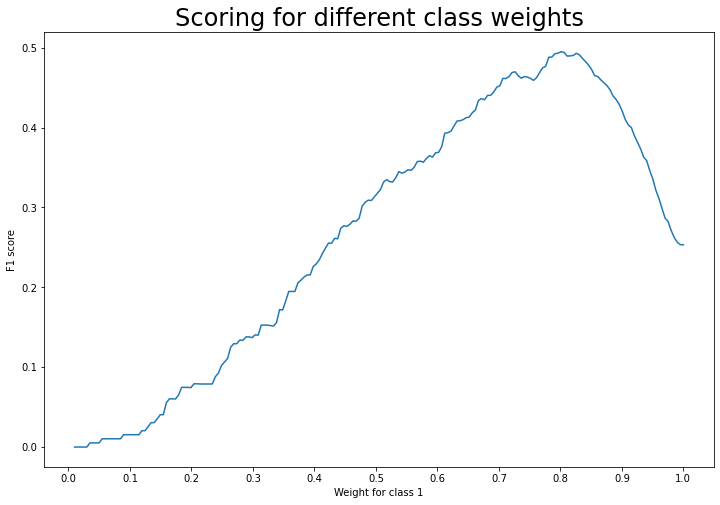

In [133]:
# Hypertuning Parameters to find the best class_weight parameter
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, param_grid= param_grid, cv=StratifiedKFold(), n_jobs=-1, scoring='f1', verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [136]:
# Initializing and fitting Logistic Regression Model 
lr = LogisticRegression(random_state=133, max_iter=9000, class_weight =0.80)
lr.fit(X_train, y_train)

# using our model to predict
y_pred = lr.predict(X_test)


#### Evaluation of the Model 

In [137]:
from sklearn.model_selection import cross_val_score

print("Accuracy Score:",accuracy_score(y_test, y_pred))

print(cross_val_score(lr, X_train, y_train, cv=10))

print(np.mean(cross_val_score(lr, X_train, y_train, cv=10)))

Accuracy Score: 0.8491704374057315
[0.86792453 0.86037736 0.84528302 0.84150943 0.87924528 0.88679245
 0.8754717  0.87169811 0.8490566  0.85984848]
0.8637206975414523


              precision    recall  f1-score   support

       False       0.87      0.96      0.92       565
        True       0.47      0.19      0.28        98

    accuracy                           0.85       663
   macro avg       0.67      0.58      0.60       663
weighted avg       0.81      0.85      0.82       663



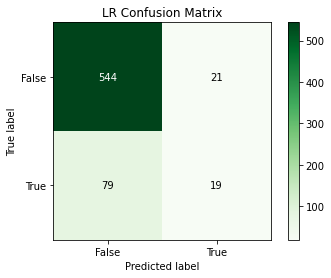

In [138]:
# Model's results 
print(classification_report(y_test, y_pred))

#Model's results displayed as confusion matrix 
skplt.metrics.plot_confusion_matrix(y_test, y_pred, title = "LR Confusion Matrix", cmap = 'Greens');


#### Model Conclusions

**Overall I feel the logistic regression model did okay. The accuracy score looks good sitting at a average of 0.863% after cross validation. My concern is the significantly lower F1 score for true samples. The models was only able to accurately label this category 20% of the time. Looking at the support values it is clear that we do not have sufficent data for churned customers. Lets see if we can try a more robust model to get a better result.**

## Random Forest Classifier

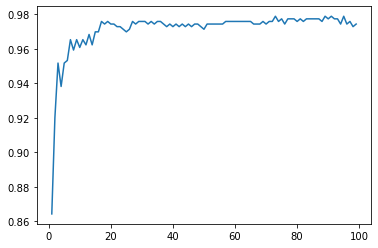

In [139]:
# Hyper Parameter Tuning for Random Forest model
numberoftrees = range(1, 100)
scores = []

# for loop
for n in numberoftrees:
    # in the n_estimators parameter, we're going to be testing all the values found in our range
    rf = RandomForestClassifier(n_estimators=n, random_state=1337)
    # fitting our model
    rf.fit(X_train, y_train)
    #prediction
    y_pred = rf.predict(X_test)
    # appending our result to variable scores
    scores.append(accuracy_score(y_test, y_pred))

# plotting our results
plt.plot(numberoftrees, scores)

**Looks like we are hitting a peak score with a n_estimator value of around 75. Lets initiate the model and plug in the findings.** 

In [140]:
# Initilizing Random Forst model and fitting 
rf = RandomForestClassifier(n_estimators=76)
rf.fit(X_train, y_train)

# using our model to predict
y_pred = rf.predict(X_test)


#### Model Evaluation

In [141]:
from sklearn.model_selection import cross_val_score

print("Accuracy Score:",accuracy_score(y_test, y_pred))

print(cross_val_score(lr, X_train, y_train, cv=10))

print(np.mean(cross_val_score(lr, X_train, y_train, cv=10)))


Accuracy Score: 0.9622926093514329
[0.86792453 0.86037736 0.84528302 0.84150943 0.87924528 0.88679245
 0.8754717  0.87169811 0.8490566  0.85984848]
0.8637206975414523


              precision    recall  f1-score   support

       False       0.96      1.00      0.98       565
        True       1.00      0.74      0.85        98

    accuracy                           0.96       663
   macro avg       0.98      0.87      0.92       663
weighted avg       0.96      0.96      0.96       663



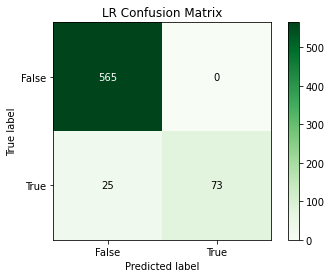

In [142]:
# Model's results 
print(classification_report(y_test, y_pred))

#Model's results displayed as confusion matrix 
skplt.metrics.plot_confusion_matrix(y_test, y_pred, title = "LR Confusion Matrix", cmap = 'Greens');

#### Model Conclusions

**The results for the Random Forest model are looking much more promising. It looks like the false positives for customer churn have decreased from 79 to 25. The F1 score also jumped from 0.28 to 0.85. I still feel that for both models to be more successful, I need to acquire more data points on customers that have churned. They are achieving the same accuracy score, and I feel that the lack of data on churned customers might be the cause.** 

#### Feature Importance for Random Forest 

<AxesSubplot:title={'center':'Feature Importance for Random Forest Model'}>

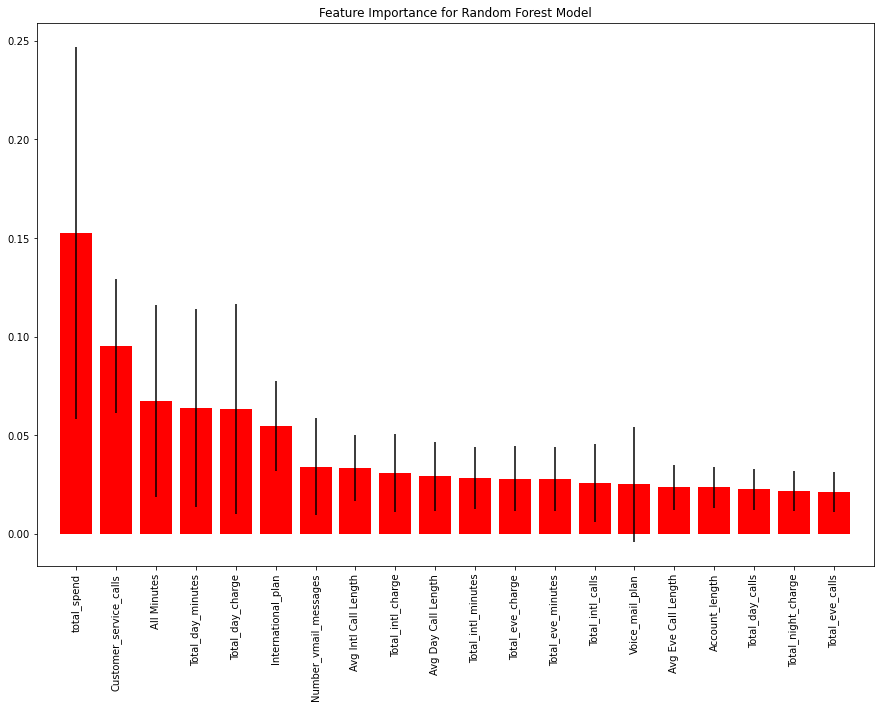

In [144]:
feature_names = X.columns

skplt.estimators.plot_feature_importances(rf, feature_names=feature_names, figsize=(15, 10), x_tick_rotation=90, title = 'Feature Importance for Random Forest Model')

**I am curious how many of our churned customers were signed up for a international_plan and how many service calls they were making. With free serivces like Zoom and Skype, the need for international phone calls doesn't seem as necessary as it used to be. Perhaps a characteristic of the companies International plan is contributing customer churn.** 

**It appears that total_spend is being weighted the heaviest in the model.**

**Lets hone into the churned customer base.** 

## Churned Customer Analysis 

Note: customers who have churned are categorized as True

In [39]:
# Creating a DF of only churned customers 
churned = df.loc[df['Churn'] == True]

In [40]:
# Creating a DF of only non-churned customers 
non_churned = df.loc[df['Churn'] == False]

In [41]:
# How many churned customers were signed up for International Calling Plans
churned.groupby('International_plan').size()

International_plan
False    346
True     137
dtype: int64

**39.5% of the churned customers were signed up for an international plan.**

In [42]:
# How many non-churned customers are signed up for International Calling Plans
non_churned.groupby('International_plan').size()

International_plan
False    2664
True      186
dtype: int64

**7% of the non-churned customers were signed up for a international plan.**

**Next, lets take a look at how service calls are distributed across the two groups of customers.**

In [43]:
churned['Customer_service_calls'].sum()

1077

In [44]:
non_churned['Customer_service_calls'].sum()

4132

**Very interesting to see that although churned customers only make up 14% of the customer base, they are responsible for 20% of service calls. Finally lets compare total spending between the two groups of customers, as well as their account lengths.**

In [45]:
round(churned['total_spend'].mean(),2)

65.36

In [46]:
round(non_churned['total_spend'].mean(),2)

58.45

**On average, churned customers were spending more than those who did not churn.**


In [47]:
round(churned['Account_length'].mean())

103

In [48]:
round(non_churned['Account_length'].mean())

101

**Not a significant difference between churned and non-churned account lengths.**

**What percentage of customers churned in each state?**

In [64]:
churn_percentage = (churned.groupby('State').size() / df.groupby('State').size() * 100).sort_values(ascending = False)
churn_percentage

State
California              26.470588
New Jersey              26.470588
Texas                   25.000000
Maryland                24.285714
South Carolina          23.333333
Michigan                21.917808
Mississippi             21.538462
Washington              21.212121
Nevada                  21.212121
Maine                   20.967742
Montana                 20.588235
Arkansas                20.000000
Kansas                  18.571429
New York                18.072289
Minnesota               17.857143
Pennsylvania            17.777778
Massachusetts           16.923077
Connecticut             16.216216
North Carolina          16.176471
New Hampshire           16.071429
Georgia                 14.814815
Delaware                14.754098
Oklahoma                14.754098
Oregon                  14.102564
Utah                    13.888889
Colorado                13.636364
Kentucky                13.559322
South Dakota            13.333333
Ohio                    12.820513
Florida 

## Conclusions/Next Steps  

After analyzing the telecom companies customer data, I was able to draw the following conclusions:

* It is a positive sign for the company that out of the 3333 customers in the database, only 14% of them were churned. It would be beneficial to have access to more data for churned customers. This would help to give the models more information to train on and improve their ability to predict for churn. If the data provided is just a snapshot of the companies total data. I would request more data for training and analysis. 




* When looking at how much money is generated by each type of call (day, evening, night, international) it is pretty clear that international calls are making up a very small portion of the companies income. With access to free calling apps like zoom and skype, international calling could soon be a service phone companies are no longer bundling into plans. It is likely this trend will continue over time as a higher percent of the population becomes comfortable using these newer communication platforms. 36% of churned customers were signed up for International Calling plans. I would suggest looking at how the phone plans are bundled. Are customers able to opt out of International Calling plans if they do not require them?. Also, it appears that although making up a small percentage of total calls, international calls tend to be the longest on average. 





* One of the highest correlated variables related to churn was Customer Service Calls. This was shown in the correlation matrix as well as the Feature Importance graph for the Random Forest model. My recommendation would be to hone in on specific hot spots for service calls. It might be worth allocating more resources to these regions. Long turn around times and failure to solve customer issues will result in unsatisfied customers. My recommendation would be to investigate staffing levels in the high volume areas, as well as one on ones or team meetings with customer service teams to ensure there are no gaps in employee knowledge or if any customer service protocols could be streamlined. 






* The income for the company is pretty well spread out across the States. There are a few outliers at the top and bottom of the list. It might be worth working with the marketing team to gain more traction in the underperforming states. The bottom 5 states in terms of number of customers were Alaska(52),Louisiana(51),Pennsylvania(45)Iowa(44) and California(34). Some of these States also displayed the highest percentage of customer churn.



* My main recommendation was that we need more data on customers who have churned. With a larger data set,buliding an unsupervised clustering model could help with grouping customers into further sub-sets. The company would be able to better understand the behaviour of their customers. This could help the marketing team with personilizing ad campaigns.


* I do not feel that there are any unethical implications regarding this data set. Since I have no demographic information about the customers themselves or, the context for their phone activity, I am only able to make observations on the customer’s phone usage and which State they live in. 
